## Init: Import packages

In [1]:
# general
import numpy as np
import pandas as pd
import math
# plots
import matplotlib.pyplot as plt
#sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_boston

## Solution 1: Evaluating regression learners

### a, b) 

See sol_eval_1.pdf

### c) 

 We fit the polynomial and linear learner and then compute the squared and absolute differences between their
respective predictions and the true target values:

In [2]:
# define train data including outlier
np.random.seed(43)
x_train = np.linspace(10, 15, num = 50)
y_train = 10 + 3 * np.sin(0.15 * math.pi * x_train) + np.random.normal(loc=0.0, scale=0.5, size= len(x_train))
# Write dictionary for pandas Data Frame to save training data
dic_train = {'y': y_train, 
             'x': x_train}
data_train = pd.DataFrame(dic_train)
print(data_train.head())

          y          x
0  7.128700  10.000000
1  6.549227  10.102041
2  6.824611  10.204082
3  6.763703  10.306122
4  7.484359  10.408163


In [3]:
# define test data
np.random.seed(2238)
x_test = np.linspace(10, 15, num = 50)
y_test = 10 + 3 * np.sin(0.15 * math.pi * x_test) + np.random.normal(loc=0.0, scale=0.5, size= len(x_test))
# Write dictionary for pandas Data Frame to save test data
dic_test = {'y': y_test, 
            'x': x_test}
data_test = pd.DataFrame(dic_test)
print(data_test.head())

          y          x
0  6.863954  10.000000
1  5.927873  10.102041
2  6.616488  10.204082
3  7.574020  10.306122
4  6.861275  10.408163


In [4]:
# train polynomial regression
poly = PolynomialFeatures(degree = 21)
x_train_poly = poly.fit_transform(x_train.reshape(-1, 1)) #reshaping necessary because single feature
x_test_poly = poly.fit_transform(x_test.reshape(-1, 1)) #reshaping necessary because single feature
poly.fit(x_train_poly, y_train)
poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)

#train linear regression
lm_model = LinearRegression()
lm_model.fit(x_train.reshape(-1, 1), y_train) #reshaping necessary because single feature

LinearRegression()

In [5]:
# make predictions
y_poly = poly_model.predict(x_test_poly)
y_lm = lm_model.predict(x_test.reshape(-1, 1))

# compute errors
abs_differences = pd.DataFrame(np.column_stack([y_poly, y_lm])).apply(lambda y: abs(data_test.loc[:, 'y']-y)) #apply is componentwise
errors_mse = abs_differences.apply(lambda x: x**2).mean() #** is power symbol
errors_mae = abs_differences.mean()

print("MAE for Polynomial and Linear fit:", errors_mae, sep='\n')
print("MSE for Polynomial and Linear fit:", errors_mse, sep='\n')

MAE for Polynomial and Linear fit:
0    0.436762
1    0.421898
dtype: float64
MSE for Polynomial and Linear fit:
0    0.266721
1    0.276253
dtype: float64


The picture is inconclusive: based on MSE, we should prefer the complex polynomial model, while MAE tells us
to pick the linear one. It is important to understand that the choices of inner and outer loss functions encode our
requirements and may have substantial impact on the result. Our learners differ strongly in their complexity:
we have an extremely flexible polynomial and a very robust (though perhaps underfitting) linear one. If, for
example, our test data contains an extreme point far from the remaining observations, the polynomial model
might be able to fit it fairly well, while the LM incurs a large MSE because the distance to this point enters
quadratically. The MAE, on the other hand, is more concerned with small residuals, and there, our LM fares
better. Here, following the MAE assessment would signify preference for a robust model.

However, we must keep in mind that our performance evaluation is based on a single holdout split, which is
not advisable in general and particularly deceptive with so little data. For different test data we quickly get
in situations where the polynomial has both worse MSE and MAE – after all, slapping a learner with 21 + 1
learnable parameters on a 50-points data set should strike you as a rather bad idea.

Take-home message: the choice of our performance metric matters, and making decisions based on a single
train-test split is risky in many data settings.

## Solution 2: Importance of train-test split

### a)

Get the data, define a task and corresponding train-test split, and predict with trained model:

In [6]:
# boston housing from original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
boston = pd.DataFrame(data[:,np.r_[4,7]], columns= ["NOX", "DIS"])
boston = boston.sort_values("DIS") # sort for "DIS", does not reset index
boston.reset_index(drop = True, inplace = True)

# load_boston() deprecated, but still functional in our sklearn version
# boston_dataset = load_boston()
# boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names).loc[:, ["DIS", "NOX"]]

boston.head()

,NOX,DIS
0,0.668,1.1296
1,0.668,1.1370
2,0.631,1.1691
3,0.668,1.1742
4,0.659,1.1781


In [7]:
# Seperate target and feature for test and training set
nox = boston.loc[:,["NOX"]]
dis = boston.loc[:,["DIS"]]

X_train = dis.loc[:9,]
X_test = dis.loc[10:,] # index is also saved, thus index starts in X_test at 10, not 0

y_train = nox.loc[:9,]
y_test = nox.loc[10:,]

In [8]:
#train linear learner
lm_boston = LinearRegression()
lm_boston.fit(X = X_train, y = y_train)

pred = lm_boston.predict(X_test)

print("MSE of test data: ", mean_squared_error(y_test, pred))

MSE of test data:  1.5245119659277129


### b) 

See sol_eval_1.pdf

### c)

We repeat the above procedure for different train-test splits like so:


In [9]:
split_ratio = np.linspace(0.1, 0.9, num = 9)

result = pd.DataFrame()
for i in range(10):
    err = []
    for split in split_ratio:
        X_train, X_test, y_train, y_test = train_test_split(dis, nox, test_size = split, random_state=i+10)
        lm_boston.fit(X = X_train, y = y_train)
        pred = lm_boston.predict(X_test)
        err.append(mean_squared_error(y_test, pred))
    result[i] = err
    
errors = result.transpose()
errors.columns = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"]

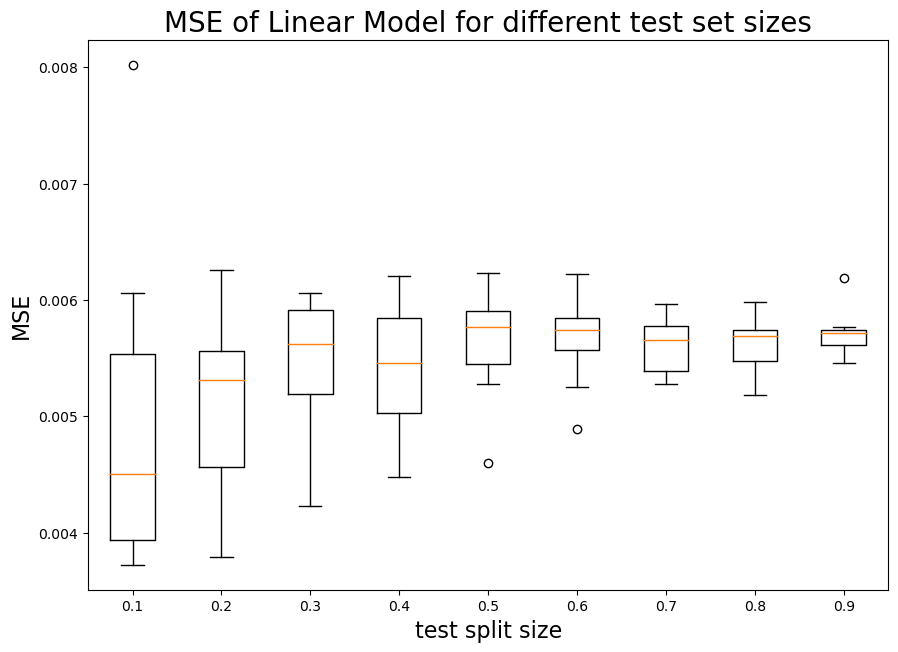

In [10]:
# plot your errors
# instantiate plot
fig = plt.figure(figsize =(8, 5.5))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(errors)
# x-axis labels
ax.set_xticklabels(["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"])
# Adding title
plt.title("MSE of Linear Model for different test set sizes", size=20)
plt.xlabel('test split size', size=16)
plt.ylabel('MSE', size=16)
# show plot
plt.show()